In [17]:
import numpy as np
import pandas as pd
import re
from termcolor import colored
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
from gensim.models import Word2Vec, KeyedVectors

Using TensorFlow backend.


In [3]:
df_software = pd.read_json('data/Software_5.json', lines = True, encoding='utf-8')
df_science = pd.read_json('data/Industrial_and_Scientific_5.json', lines = True,encoding='utf-8')

In [4]:
df = pd.concat([df_software, df_science])

In [5]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN


In [6]:
df_text = df['reviewText'].values
df_score = df['overall'].values

In [7]:
text = []
score = []
c = 0 

for i in range(len(df_text)):
    if str(df_text[i]) != "nan":
        text.append(df_text[i])
        score.append(df_score[i])
    else:
        c += 1
#         print(i)

In [8]:
def cleanText(string, ):
    # print(colored('---------- NEW ----------', 'green', attrs=['bold']))
    # print(string)
    string = re.sub(r"[-()\"#/@;:<>{}+=./|.!?,~]", "", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    # print(colored('---------- CLEAN ----------', 'green', attrs=['bold']))
    # print(string.strip().lower())
    return string.strip().lower()

In [9]:
cleanT = []
for t in text:
    cleanT.append(cleanText(t))

In [26]:
stop_words =  ['if', 'do', '\'ve' , 'program' , 'window',  'windows', 'even' ,  'computer' ,'product' ,'\'ll' , 'use', 'used', 'one' ,'n\'t' , '\'re' , '\'s' ,'few', "it's", "shouldn't", 'myself', 'its', 'has', 'with', 'been', 'can', 'won', "you'll", 'below', "weren't", 'into', 'him', 'this', 'above', 'our', "needn't", 'here', 'i', 'me', 'all', 're', "won't", 'don', 'should', 'such', 'or', 'for', "couldn't", 'what', "should've", 'does', 'hers', 'other', "that'll", "doesn't", "wasn't", 'once', 'while', 'between', 'mightn', "hasn't", 'too', 'up', 'before', 'their', 'himself', 'it', "you'd", 'some', 'themselves', 'ain', 'an', 'ours', 'at', 'haven', 'about', 'just', 'shouldn', 'o', 'both', 'out', "isn't", 'll', 'ma', 'you', "haven't", 'only', 'hadn', 'those', 'they', 'against', 'down', 'over', 't', 'she', 'again', 'why', 'did', 'wouldn', 'a', 'when', 'your', 'ourselves', 'who', 'having', 'on', 'y', 'theirs', 'being', 'herself', 'nor', 'that', 'by', "don't", "mustn't", "shan't", 'because', 'not', 'under', 'are', 'he', 'own', "you've", 'there', 'yours', 'and', 'most', "mightn't", 'have', 'doing', 'during', 'couldn', "didn't", 'will', 'weren', 'd', 'were', "she's", "wouldn't", 'isn', 'then', 'doesn', 'wasn', 'itself', 'now', 'didn', 'these', 'them', 'needn', 'yourself', 'shan', 'is', 'more', 'be', "you're", 'than', 'after', 'aren', 'how', 'where', 'which', 'in', "hadn't", 'further', 'no', 'yourselves', 'as', 'whom', 'to', 'hasn', 'mustn', 'through', 'the', 'm', 's', 'very', 'we', 'each', 'until', 'same', "aren't", 'was', 'my', 'so', 'from', 've', 'am', 'had', 'his', 'but', 'off', 'any', 'of', 'her']
punctuation = list(string.punctuation)
stop = stop_words + punctuation

In [27]:
clean_text = []

for s in cleanT:
    sentence = s
    sent_words = sentence.split()
    words = [i for i in sent_words if i not in stop]
    output = ' '.join(words)
    clean_text.append(output)

In [28]:
positive_reviews = []
positive_score = []
negative_reviews = []
negative_score = []

for i in range(len(score)):
    if score[i] == 5:
        positive_reviews.append(clean_text[i])
        positive_score.append(score[i])
    elif score[i] == 1:
        negative_reviews.append(clean_text[i])
        negative_score.append(score[i])

In [29]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(str(data))
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color=color, width=2500, height=2000).generate(data)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [30]:
negative_words = ""

for i in range(len(negative_reviews)):
    negative_words += str(negative_reviews[i])

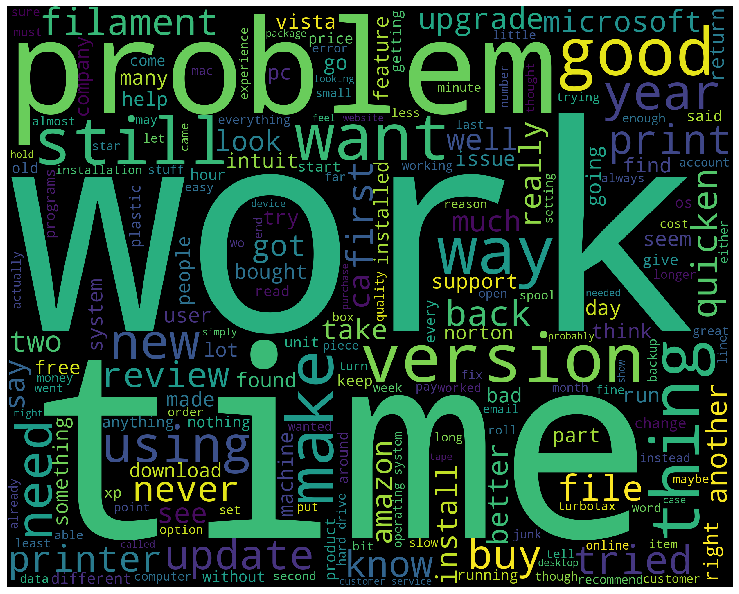

In [15]:
wordcloud_draw(negative_words)

In [16]:
positive_words = ""

for i in range(len(positive_reviews[0:1000])):
    positive_words += str(positive_reviews[i])

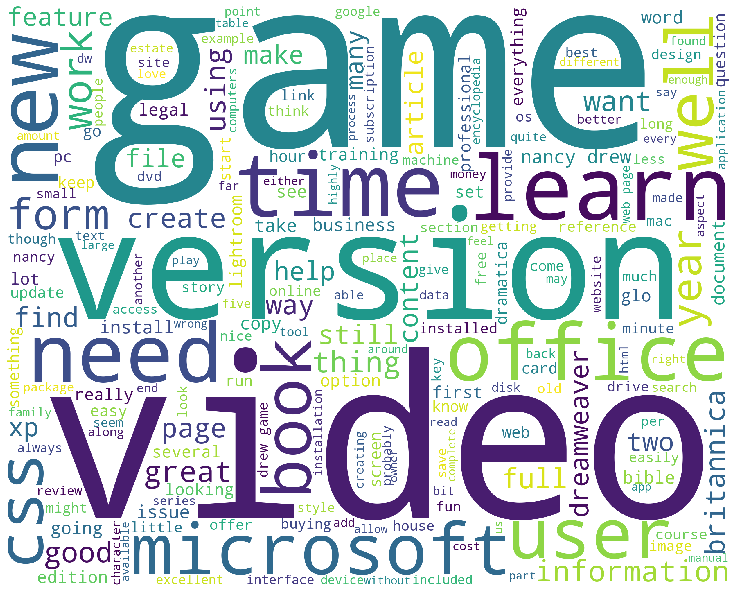

In [17]:
wordcloud_draw(positive_words, 'white')

In [40]:
 corpus = []

for review in clean_text:
    sent_words = review.split()
#     print(list(sent_words))
    corpus.append(list(sent_words))
# print(corpus)

In [60]:
model = Word2Vec(corpus,min_count=1,size=200)

In [63]:
model.wv.most_similar('great')

[('fantastic', 0.8101750016212463),
 ('awesome', 0.7719845771789551),
 ('excellent', 0.7507606148719788),
 ('wonderful', 0.6966796517372131),
 ('good', 0.6846572160720825),
 ('perfect', 0.6437108516693115),
 ('nice', 0.6431217789649963),
 ('amazing', 0.6279322504997253),
 ('terrific', 0.6262813806533813),
 ('incredible', 0.6242130994796753)]

In [64]:
embedding_matrix = np.zeros((len(model.wv.vocab), 200))

In [65]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
for i in range(len(model.wv.vocab)):
    embedding_vector = model.wv[model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [67]:
embedding_matrix

array([[ 5.21457672e-01,  4.29170400e-01,  4.34049398e-01, ...,
        -1.91393375e-01,  8.62830818e-01,  2.98716538e-02],
       [-5.33664703e-01,  2.03331304e-03,  3.73040408e-01, ...,
         6.40899181e-01,  2.19505310e-01,  9.35454726e-01],
       [-2.40895763e-01,  1.21148074e+00, -1.00304663e+00, ...,
         7.92428553e-01,  3.27485025e-01,  2.35456616e-01],
       ...,
       [-1.70267429e-02,  6.69561734e-04,  1.37451466e-03, ...,
        -7.00552016e-03, -4.15136339e-03,  9.07372124e-03],
       [-3.85415391e-03, -4.40668408e-03,  9.27361939e-03, ...,
        -5.76452585e-05, -1.35321019e-03,  2.84527102e-03],
       [-5.04503492e-04, -4.50880325e-04,  8.91648605e-03, ...,
        -7.16536073e-04, -9.16431658e-04,  2.65135051e-04]])

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(clean_text, score, test_size = 0.3 , random_state = 0)

In [73]:
print('X_train: ',len(X_train))
print('X_test: ',len(X_test))
print('Y_train: ',len(Y_train))
print('Y_test: ',len(Y_test))

X_train:  62904
X_test:  26960
Y_train:  62904
Y_test:  26960


In [74]:
def encodeData(y):
        y = np.reshape(y, (-1, 1))
        onehotencoder  =  OneHotEncoder()
        y = onehotencoder.fit_transform(y).toarray()
        return y

In [76]:
warnings.simplefilter(action='ignore', category=FutureWarning)
y_train = encodeData(Y_train)
y_test = encodeData(Y_test)

In [77]:
print(y_train.shape)
print(y_train[0:5])
print(y_test.shape)
print(y_test[0:5])

(62904, 5)
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
(26960, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [78]:
def tokenizeData(data ,X_train, X_test, max_words, maxlen):
        
        max_words = max_words

        # Tokenisation and making data into a LIST
        tokenizer = Tokenizer(num_words = max_words)
        tokenizer.fit_on_texts(data)
        print('LENGTH Vocab = ', len(tokenizer.word_index))
        # print("word_index : ",tokenizer.word_index)
        print(colored('---------- BEFORE ----------', 'green', attrs=['bold']))
        print(X_train[1])
        print(colored('--------------------', 'blue', attrs=['bold']))
        print(X_test[1])
        X_train = tokenizer.texts_to_sequences(X_train)
        X_test = tokenizer.texts_to_sequences(X_test)

        print(colored('---------- TOKEN ----------', 'red', attrs=['bold']))
        print(X_train[1])
        print(colored('--------------------', 'blue', attrs=['bold']))
        print(X_test[1])
        maxlen = maxlen

        X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
        X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

        print(colored('---------- PAD ----------', 'green', attrs=['bold']))
        print(X_train[1])
        print(colored('--------------------', 'blue', attrs=['bold']))
        print(X_test[1])
        return X_train, X_test

In [79]:
max_words = 70000
max_len = 100

x_train, x_test = tokenizeData(clean_text, X_train, X_test, max_words, max_len)

LENGTH Vocab =  72032
---------- BEFORE ----------
know begin software let start saying user friendly lot bloatware comes along really disappointed fact kept getting errors trying upload tube point option incorporated ca finally get video uploaded took forever hard find support website plus want charge calling ask advice get software work properly like fact many options available software hardly get opportunity software always freezes hit ctrl alt delete get crappy software screen tried using software several months order really form accurate opinion honestly ca recommend software anyone want continuously feel frustrated editing videos pinnacle studio 16 ultimate perfect software finally given uninstalled software least corel video suite little user friendly
--------------------
installed jet 15 inch planer per instructions drill holes tighten knob sensor bar final step calibration still great deal lateral movement sensor bar instruction says tighten knob securely still fix problem not